In [238]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
from scipy import stats
from itertools import *
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest,f_classif,SelectPercentile
from sklearn.linear_model import Lasso,lasso_path,LassoCV
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc,roc_auc_score
from scipy.stats import sem
from pandas import Series,DataFrame
from sklearn.externals import joblib
from sklearn.model_selection import StratifiedKFold
from scipy import interp
from sklearn.feature_selection import SelectFromModel
import pickle
from sklearn.externals import joblib
%matplotlib inline
sns.set_style('white')
plt.rcParams['figure.dpi'] = 300
plt.show()

In [239]:
def read_file(path,groupid):
    df = pd.read_csv(path,index_col=0,encoding='gbk',header=[0,1,2])
    cols = ['_'.join(col[::-1]) for col in list(df.columns)]
    new_df = pd.DataFrame(df.values, index=df.index, columns=cols)
    
    new_df = new_df.replace(u'是',u'0')
    new_df = new_df.replace(u'否',u'1') 
    new_df = new_df.replace(u'囊',u'0')
    new_df = new_df.replace(u'实',u'1') 
    new_df = new_df.replace(u'恶',u'0')
    new_df = new_df.replace(u'良',u'1') 
    
    
    grouped = new_df.groupby('custom_custom_voi_name')
    uniquekeys=[]
    data = []
    for k,g in grouped:
        groups=list(g)
        uniquekeys=k
        print uniquekeys
    data = grouped.get_group(groupid)
    
    X = data.iloc[:,11:]
    y = data.iloc[:,10]
    #cli = data.iloc[:,7:14]

    #ss = StandardScaler().fit(X)
    #X_std = ss.transform(X)
    #X = DataFrame(X_std,index=X.index,columns=X.columns)
    
    features = X.columns
    
    print len(X)
    print len(y)
    print X
    print y
    return X,y,features

In [240]:
def train_test(X,y,random):
    grouped = y.groupby(y)
    uniquekeys=[]
    data = []
    for k,g in grouped:
        groups=list(g)
        uniquekeys=k
    y0 = grouped.get_group('0')
    y1 = grouped.get_group('1')
    X0 = DataFrame(X,index=y0.index)
    X1 = DataFrame(X,index=y1.index)
    
    X_train0, X_test0, y_train0, y_test0 = train_test_split(X0, y0, test_size=.3,random_state=random)
    X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=.3,random_state=random)
    
    X_train = pd.concat([X_train0,X_train1],axis=0,join='inner')
    X_test = pd.concat([X_test0,X_test1],axis=0,join='inner')
    y_train = pd.concat([y_train0,y_train1],axis=0,join='inner')
    y_test = pd.concat([y_test0,y_test1],axis=0,join='inner')

    y_train = np.array(y_train, dtype = int)
    y_test = np.array(y_test, dtype = int)
    
    ss = StandardScaler().fit(X_train)
    X_train_std = ss.transform(X_train)
    X_train = DataFrame(X_train_std,index=X_train.index,columns=X_train.columns)
    
    X_test_std = ss.transform(X_test)
    X_test = DataFrame(X_test_std,index=X_test.index,columns=X_test.columns)
    
    return X_train,y_train,X_test,y_test

In [241]:
def move_lowvariance(X,y):
    sel = VarianceThreshold(threshold=(.08 * (1 - .08)))
    sel_X = sel.fit_transform(X)
    result = sel.get_support()
    features = X.columns
    features_split = []
    sel_features = []
    sel_features_split = []
    first = []
    sel_first = []
    for index, item in enumerate(features):
        item_split = item.split('_')
        features_split.append(item_split)
        first.append(item_split[0])    
        if result[index]:
            sel_features.append(item)
            sel_features_split.append(item_split)
            sel_first.append(item_split[0])
    print("features reduced from {0} to {1}".format(len(features),len(sel_features)))
    X = X[sel_features]
    y = y
    features = sel_features
    return X,y,features

In [242]:
def select_KBest(X,y):
    sel = SelectKBest(f_classif,k = 'all').fit(X,y)
    scores = sel.scores_
    pvalue = sel.pvalues_
    features = X.columns
    result = sel.get_support()
    sort_features = []
    for index, item in enumerate(features):
        if result[index]:
            sort_features.append(item)
    # 将特征按分数 从大到小 排序  
    named_scores = zip(features, scores, pvalue)
    sorted_named_scores = sorted(named_scores,key = lambda z:z[1])
    sorted_pvalue = [each[2] for each in sorted_named_scores if each[2]<0.05]  
    sorted_scores = [each[1] for each in sorted_named_scores]  
    sorted_names = [each[0] for each in sorted_named_scores]
    print len(sorted_pvalue)
    num = len(sorted_pvalue)
    sel_features = sorted_names[0:num]
    X = X[sel_features]
    y =y
    print("features reduced from {0} to {1}".format(len(features),len(sel_features)))
    
    num = len(sorted_pvalue)
    fe = sorted_names[0:num]
    stats_result = pd.DataFrame({'score':sorted_scores[0:num],
                             'p':sorted_pvalue[0:num]},
                            index = list(fe))
    print stats_result
    #stats_result.to_csv('C:\\Users\\hy_radcloud\\Desktop\d_20180529_duibi\\ve/sk_P_score.csv')
    sel2_result = X[fe]
    #sel2_result.to_csv('C:\\Users\\hy_radcloud\\Desktop\d_20180529_duibi\\ve/selectKbest.csv')
    
    return X,y,sel_features

In [243]:
def lasso_filter(X,y,cv):
    
    model = LassoCV(cv=cv,max_iter=2000).fit(X,y)
    selected =  -np.log10(model.alpha_)
    m_log_alphas = -np.log10(model.alphas_)
    features = X.columns
    coef = pd.Series(model.coef_, index = features)
    sel_coef = coef[coef!=0]  
    print sel_coef
    sel_features = sel_coef.index
    X = X[sel_features]
    print("features reduced from {0} to {1}".format(len(features),len(sel_features)))
    
    plt.figure()
    plt.plot(m_log_alphas, model.mse_path_, ':')
    plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',label='Average across the folds', linewidth=2)
    plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',label='alpha: CV estimate')
    plt.legend()
    plt.xlabel('-log(alpha)')
    plt.ylabel('Mean square error')
    plt.show()
    
    eps = 1e-2 # the smaller it is the longer is the path
    alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps, fit_intercept=False)
    plt.figure()
    ax = plt.gca()
    colors = cycle(['b', 'r', 'g', 'c', 'k'])
    neg_log_alphas_lasso = -np.log10(alphas_lasso)
    for coef_l, c in zip(coefs_lasso,colors):
        l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)
    plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',label='alpha: CV estimate')
    plt.xlabel('-Log(alpha)')
    plt.ylabel('coefficients')
    plt.title('Lasso Path')
    plt.axis('tight')
    plt.show()
    
    selected_coef = coef[coef!=0]  
    lasso_feature = selected_coef.index
    lasso_result = X[lasso_feature]
    lasso_result.to_csv('E:\\HYHY1113\\data_analysis\\jidasan-suihe\\liangexing\\C_lasso.csv') #需要可导出
    
    mp_coef = pd.concat([selected_coef.sort_values()])
    print mp_coef.index[1]
    print mp_coef.values[1]
    print len(mp_coef)
    #print mp_coef
    mp_coef.to_csv('E:\\HYHY1113\\data_analysis\\jidasan-suihe\\liangexing\\C_lasso-xishu.csv')
    
    return X,y,sel_features    

In [244]:
def matrix_report(y_test,y_pred):
    matrix = confusion_matrix(y_test, y_pred)
    TN = matrix[1,1]
    TP = matrix[0,0]
    FN = matrix[0,1]
    FP = matrix[1,0]
    sensitivity = TP/float(FN+TP)
    specificity = TN/float(TN+FP)
    print matrix
    print 'sensitivity = ',sensitivity
    print 'specificity = ',specificity

In [245]:
def auc_report(y_test,y_pred,y_pred_prob):
    fpr,tpr,thresholds = roc_curve(y_test,y_pred_prob, pos_label=1)
    auc_result = roc_auc_score(y_test, y_pred_prob)
    #figure
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.plot(fpr, tpr, label='area under AUC is {0}'.format(auc_result))  
    plt.legend(loc="lower right")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.rcParams['font.size'] = 12
    #plt.title('ROC curve for T2 classifier')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.show()
    #cut-off point
    i = np.arange(len(tpr))
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(thresholds, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]
    threshold_value = roc_t['threshold'].values
    print threshold_value
    print 'auc = ',auc_result

In [246]:
def model_training(X,y,clf,cv):

    X_index = X.index
    X_index = DataFrame(X_index,columns=['X_index'])
    X = np.array(X) 
    yprob = DataFrame()

    cv = StratifiedKFold(n_splits=cv)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    i = 0
    for train, test in cv.split(X, y):
        probas_ = clf.fit(X[train], y[train]).predict_proba(X[test])
        pred_ = clf.fit(X[train], y[train]).predict(X[test])
        #print probas_
        #print pred_
    # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
        matrix = confusion_matrix(y[test],pred_)
        print matrix
        yprobabi = DataFrame(probas_,index = test, columns = ['y_proba0','y_proba1'])
        y_true = DataFrame(y[test],index = test,columns = ['y_true'])
        y_pred = DataFrame(pred_,index = test,columns = ['y_pred'])
        yprobabi = pd.concat([y_true,y_pred,yprobabi],axis=1,join='inner',ignore_index = True)
        yprob = yprob.append(yprobabi)
        y_proba = yprob.sort_index()
    #y_true_pred = pd.concat([X_index,y_proba],axis=1,join='inner',ignore_index = True)
    y_proba.to_csv('E:\\HYHY1113\\data_analysis\\jidasan-suihe\\liangexing\\C_yTrain_true_pred.csv')
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Luck', alpha=.8)
    
    i = np.arange(len(tpr))
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(thresholds, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]
    threshold_value = roc_t['threshold'].values
    print 'threshold_value = '
    print threshold_value
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    print mean_auc
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
    model = pickle.dumps(clf)
    return model,mean_auc

In [247]:
def model_testing(model,X_test,y_test):

    X_index = X_test.index
    X_index = DataFrame(X_index,columns=['X_index'])
    
    clf = pickle.loads(model)
    y_pred = clf.predict(X_test)
    y_pred_prob = clf.predict_proba(X_test)[:,1]
    print clf.classes_
    
    y_pred_prob = DataFrame(y_pred_prob,index = X_index, columns = ['y_proba0'])
    y_test = DataFrame(y_test,index = X_index,columns = ['y_true'])
    y_pred = DataFrame(y_pred,index = X_index,columns = ['y_pred'])
    
    yTest_true_pred = pd.concat([y_test,y_pred,y_pred_prob],axis=1,join='inner',ignore_index = True)
    yTest_true_pred.to_csv('E:\\HYHY1113\\data_analysis\\jidasan-suihe\\liangexing\\C_yTest_true_pred.csv')
    return y_pred,y_pred_prob

In [248]:
#data = pd.read_csv('E:\\HYHY1113\\data_analysis\\jidasan-suihe\\analysis-thymus_C.csv',index_col=0,encoding='gbk')
    
path = 'E:\\HYHY1113\\data_analysis\\jidasan-suihe\\analysis-thymus_C.csv'
groupid = 'TT'
quan = read_file(path,groupid)

X = quan[0]
y = quan[1]
print len(X)
print len(y)

TT
168
168
           original_firstorder_Energy  original_firstorder_TotalEnergy  \
875180                   4.202207e+10                     1.582130e+10   
887680                   3.364529e+09                     1.444085e+09   
909131                   1.245569e+08                     7.678183e+08   
914016                   5.476122e+09                     2.878870e+10   
916525                   5.577132e+08                     2.837748e+08   
927586                   4.173094e+10                     1.586876e+10   
958618                   4.251877e+07                     2.080227e+07   
P00216643                9.360150e+08                     6.719173e+08   
P00152097                1.977725e+09                     1.222196e+09   
P00049329                1.207356e+09                     8.357105e+08   
P00127917                3.063505e+08                     1.571579e+08   
P00086243                1.476121e+09                     8.622405e+08   
1690436                  1.

In [249]:
random = 25
data = train_test(X,y,random)
X = data[0]
y = data[1]
X_test = data[2]
y_test = data[3]
#print X

In [250]:
#X_lv,y_lv,features_lv = move_lowvariance(data[0],data[1])
#print len(X_lv)
#print len(y_lv)

In [251]:
#X_kbest,y_kbest,features_kbest = select_KBest(data[0],data[1])
#print X_kbest.shape,y_kbest.shape
#X_cli_train = pd.concat([X_kbest,data2[4]],axis=1,join='inner')
#print len(X_kbest)
#print len(y_kbest)

In [252]:
#cv=8
#X_lasso,y_lasso,features_lasso = lasso_filter(X,y,cv)
#print X_lasso.shape,y_lasso.shape,features_lasso
#X_cli_train = pd.concat([X_lasso,data2[4]],axis=1,join='inner')

In [253]:
#逻辑回归
#clf = LogisticRegression(penalty='l2',class_weight='balanced',solver='newton-cg')
clf = LogisticRegression(penalty='l1',class_weight='balanced')
#clf = LogisticRegression()

#svm
#clf = svm.SVC(kernel='linear',probability=True)

'''
for j in range(3,10):
    X_lasso,y_lasso,features_lasso = lasso_filter(X,y,j)
    X_test_feature = DataFrame(X_test,index=X_test.index,columns=X_lasso.columns)
    X_test_feature.to_csv('E:\\HYHY1113\\data_analysis\\jidasan-suihe\\liangexing\\C_lasso_Test.csv') #需要可导出
    for i in range(3,10):
        print 'cv_lasso=',j
        print 'cv_ml = ',i
        model,mean_auc = model_training(X_lasso,y_lasso,clf,i)
        y_pred_train,y_proba_train = model_testing(model,X_test_feature,y_test)
        auc_report(y_test,y_pred_train,y_proba_train)
        print '#########################################'
'''

"\nfor j in range(3,10):\n    X_lasso,y_lasso,features_lasso = lasso_filter(X,y,j)\n    X_test_feature = DataFrame(X_test,index=X_test.index,columns=X_lasso.columns)\n    X_test_feature.to_csv('E:\\HYHY1113\\data_analysis\\jidasan-suihe\\liangexing\\C_lasso_Test.csv') #\xe9\x9c\x80\xe8\xa6\x81\xe5\x8f\xaf\xe5\xaf\xbc\xe5\x87\xba\n    for i in range(3,10):\n        print 'cv_lasso=',j\n        print 'cv_ml = ',i\n        model,mean_auc = model_training(X_lasso,y_lasso,clf,i)\n        y_pred_train,y_proba_train = model_testing(model,X_test_feature,y_test)\n        auc_report(y_test,y_pred_train,y_proba_train)\n        print '#########################################'\n"

original_shape_SphericalDisproportion                -0.011965
square_firstorder_Kurtosis                            0.024974
square_glszm_SmallAreaEmphasis                       -0.005748
square_glszm_SmallAreaLowGrayLevelEmphasis           -0.001384
exponential_firstorder_TotalEnergy                   -0.002234
exponential_glszm_ZoneVariance                       -0.044006
wavelet-HLL_firstorder_Median                         0.002093
wavelet-LLH_glcm_Idn                                 -0.060132
wavelet-HLH_glcm_Idmn                                -0.015768
wavelet-HLH_glszm_SizeZoneNonUniformityNormalized     0.040494
wavelet-HHH_firstorder_Skewness                      -0.026516
wavelet-HHL_glszm_GrayLevelNonUniformityNormalized   -0.013928
dtype: float64
features reduced from 1029 to 12


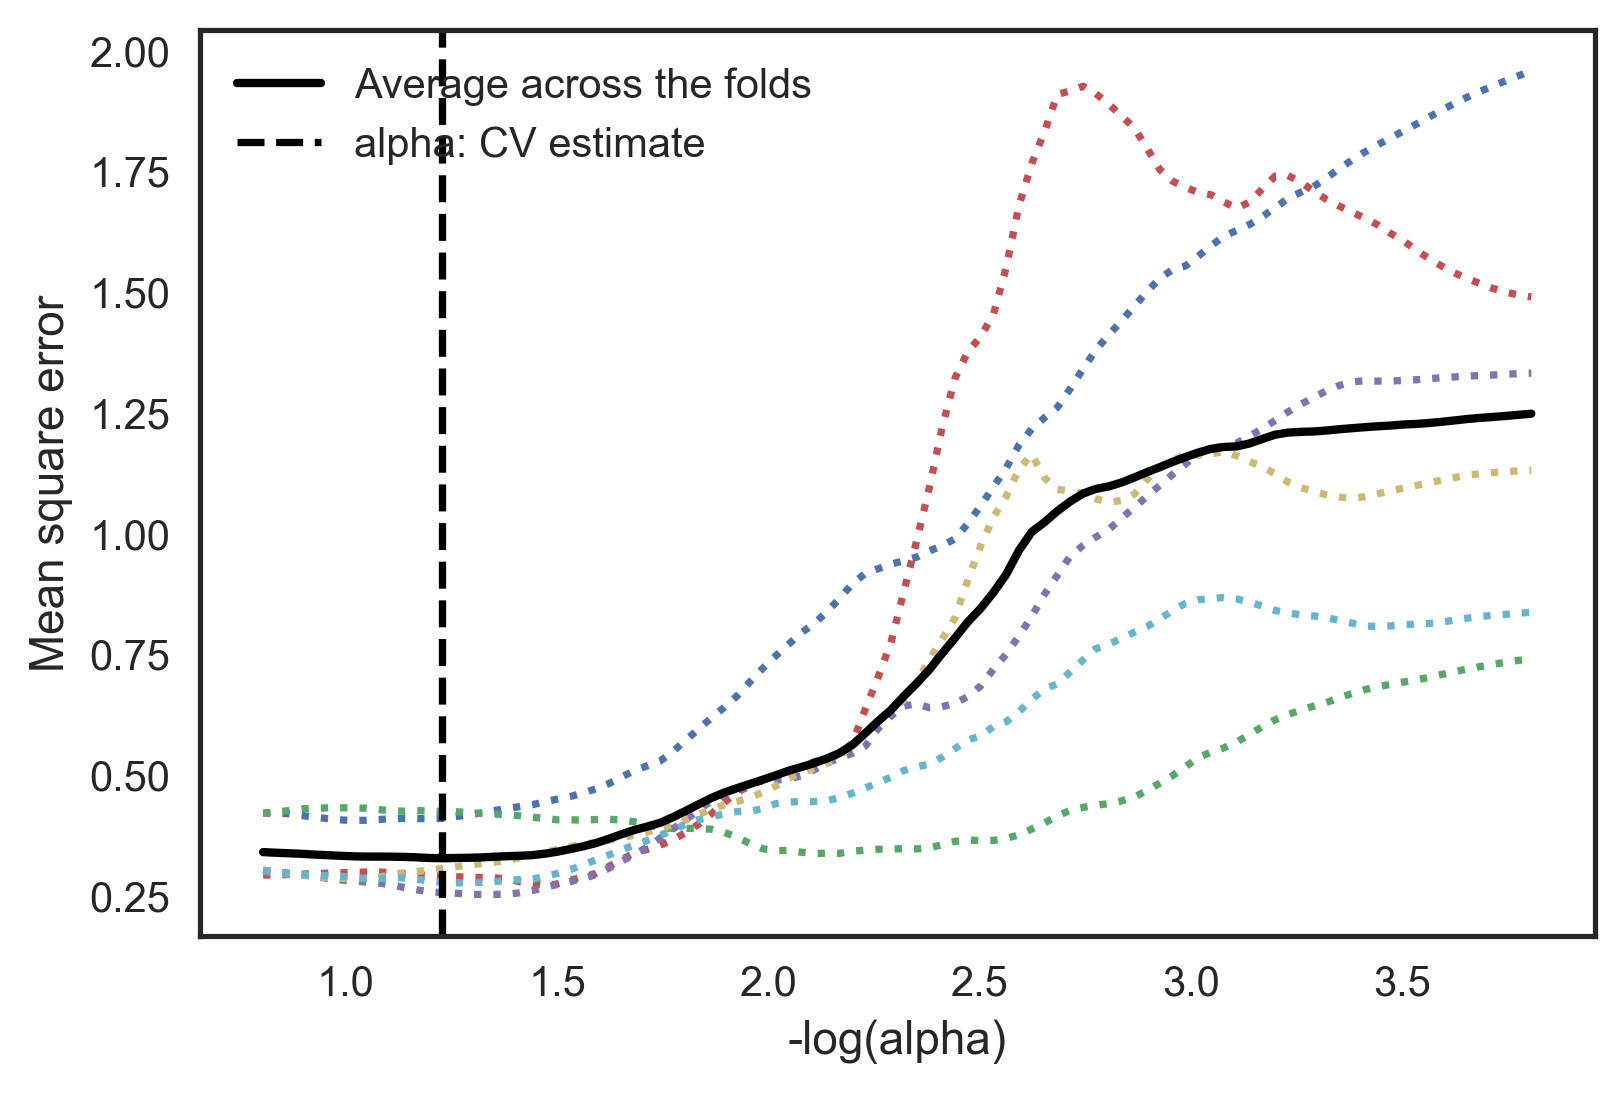

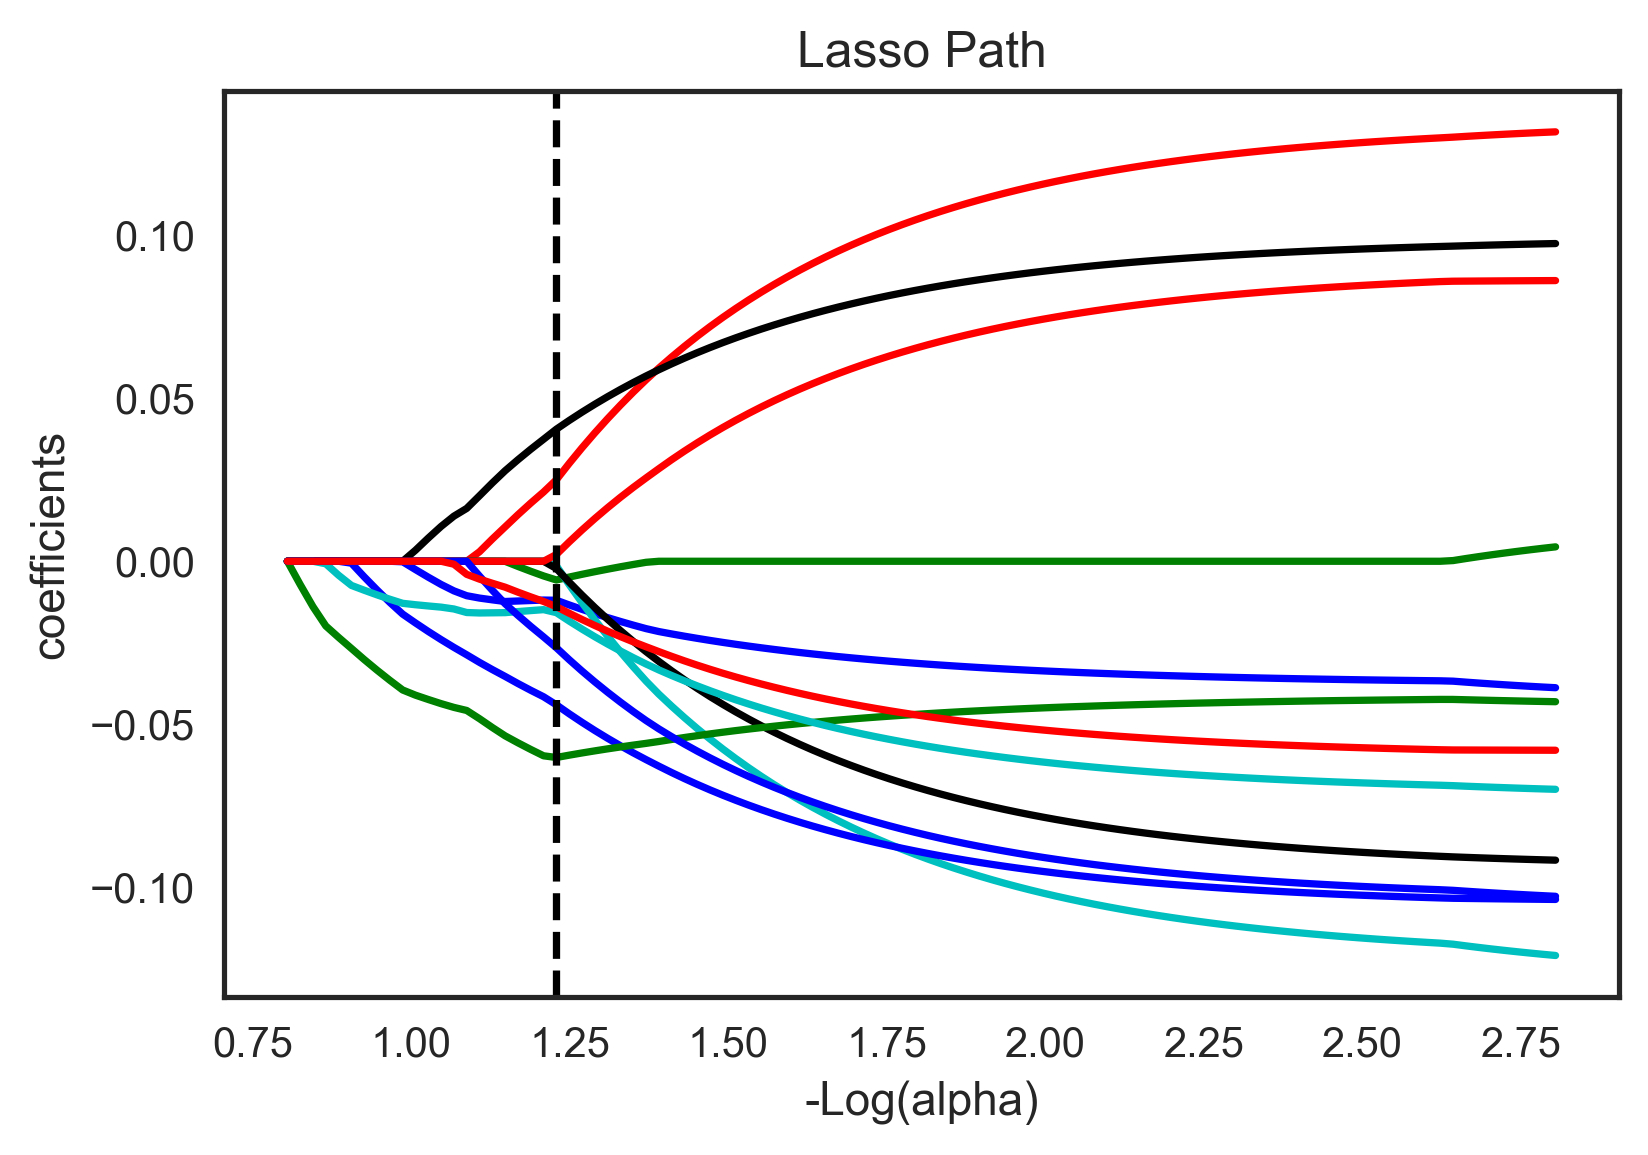

exponential_glszm_ZoneVariance
-0.0440062133194
12
[[15  3]
 [ 6 15]]
[[13  5]
 [ 7 14]]
[[12  6]
 [ 9 12]]
threshold_value = 
[ 0.46531938]
0.737774571108


D:\Anaconda\Anaconda\lib\site-packages\ipykernel\__main__.py:42: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


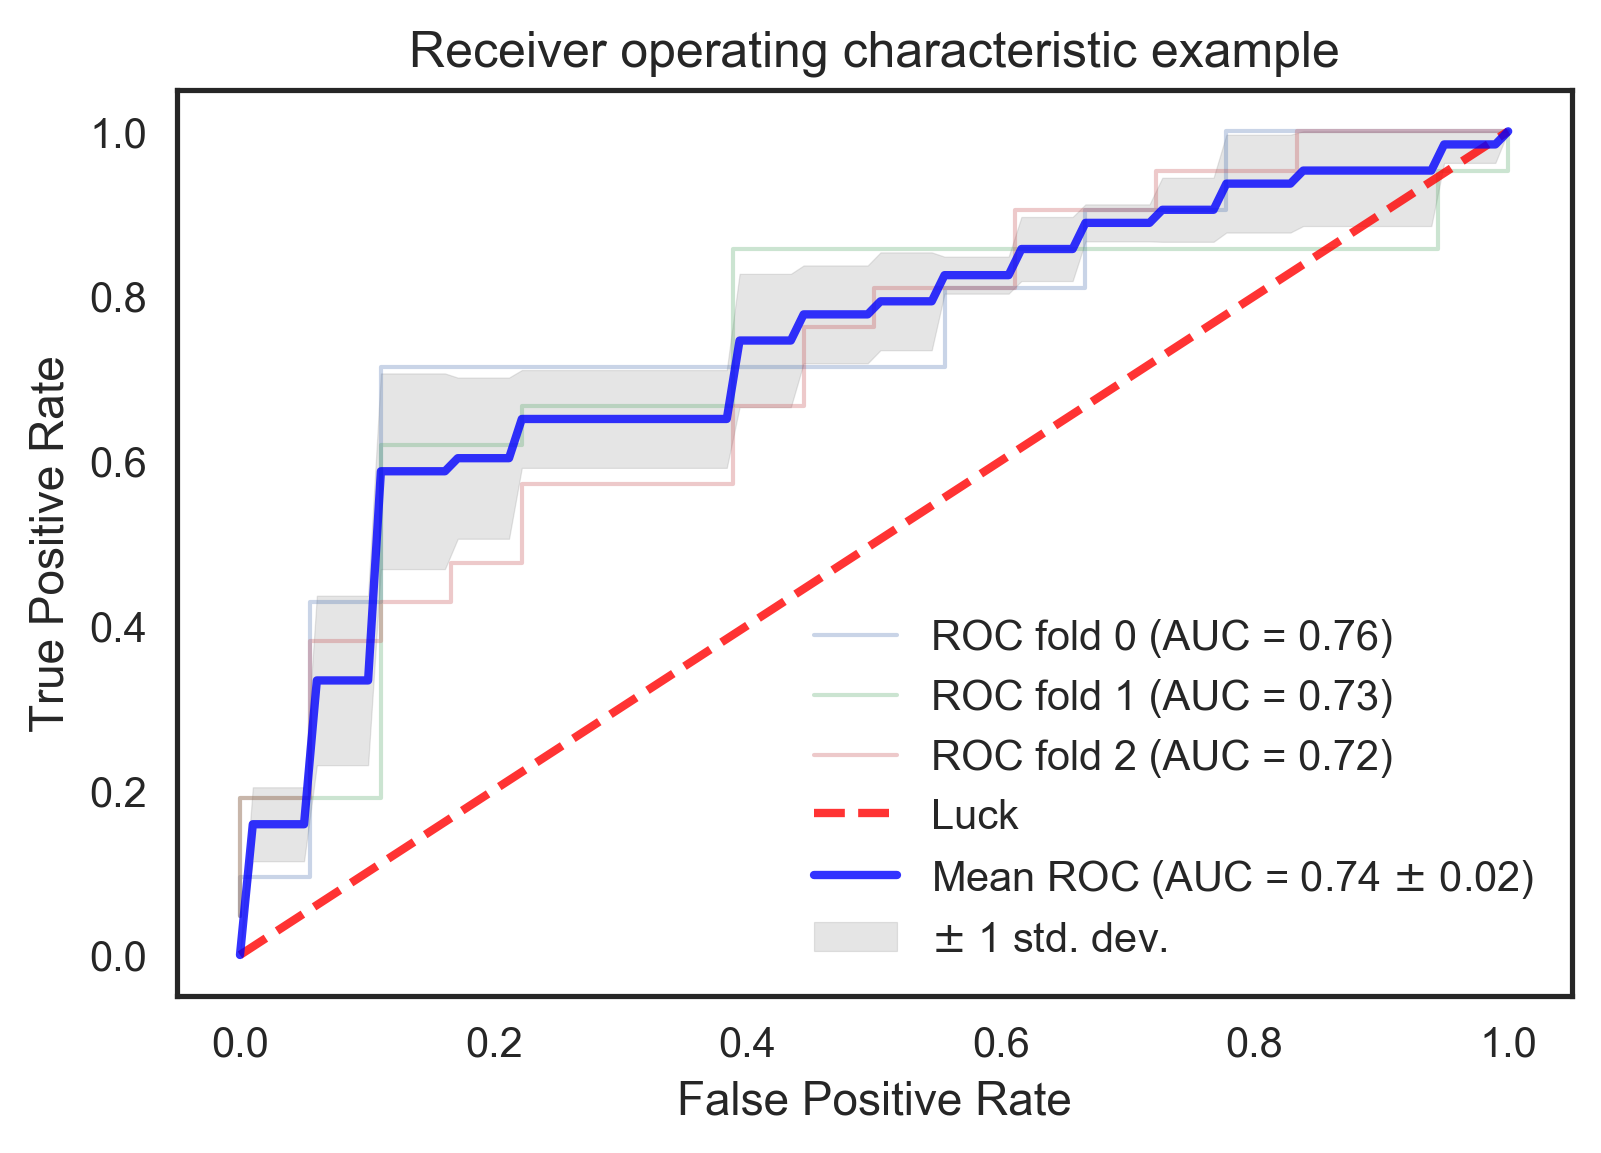

[0 1]


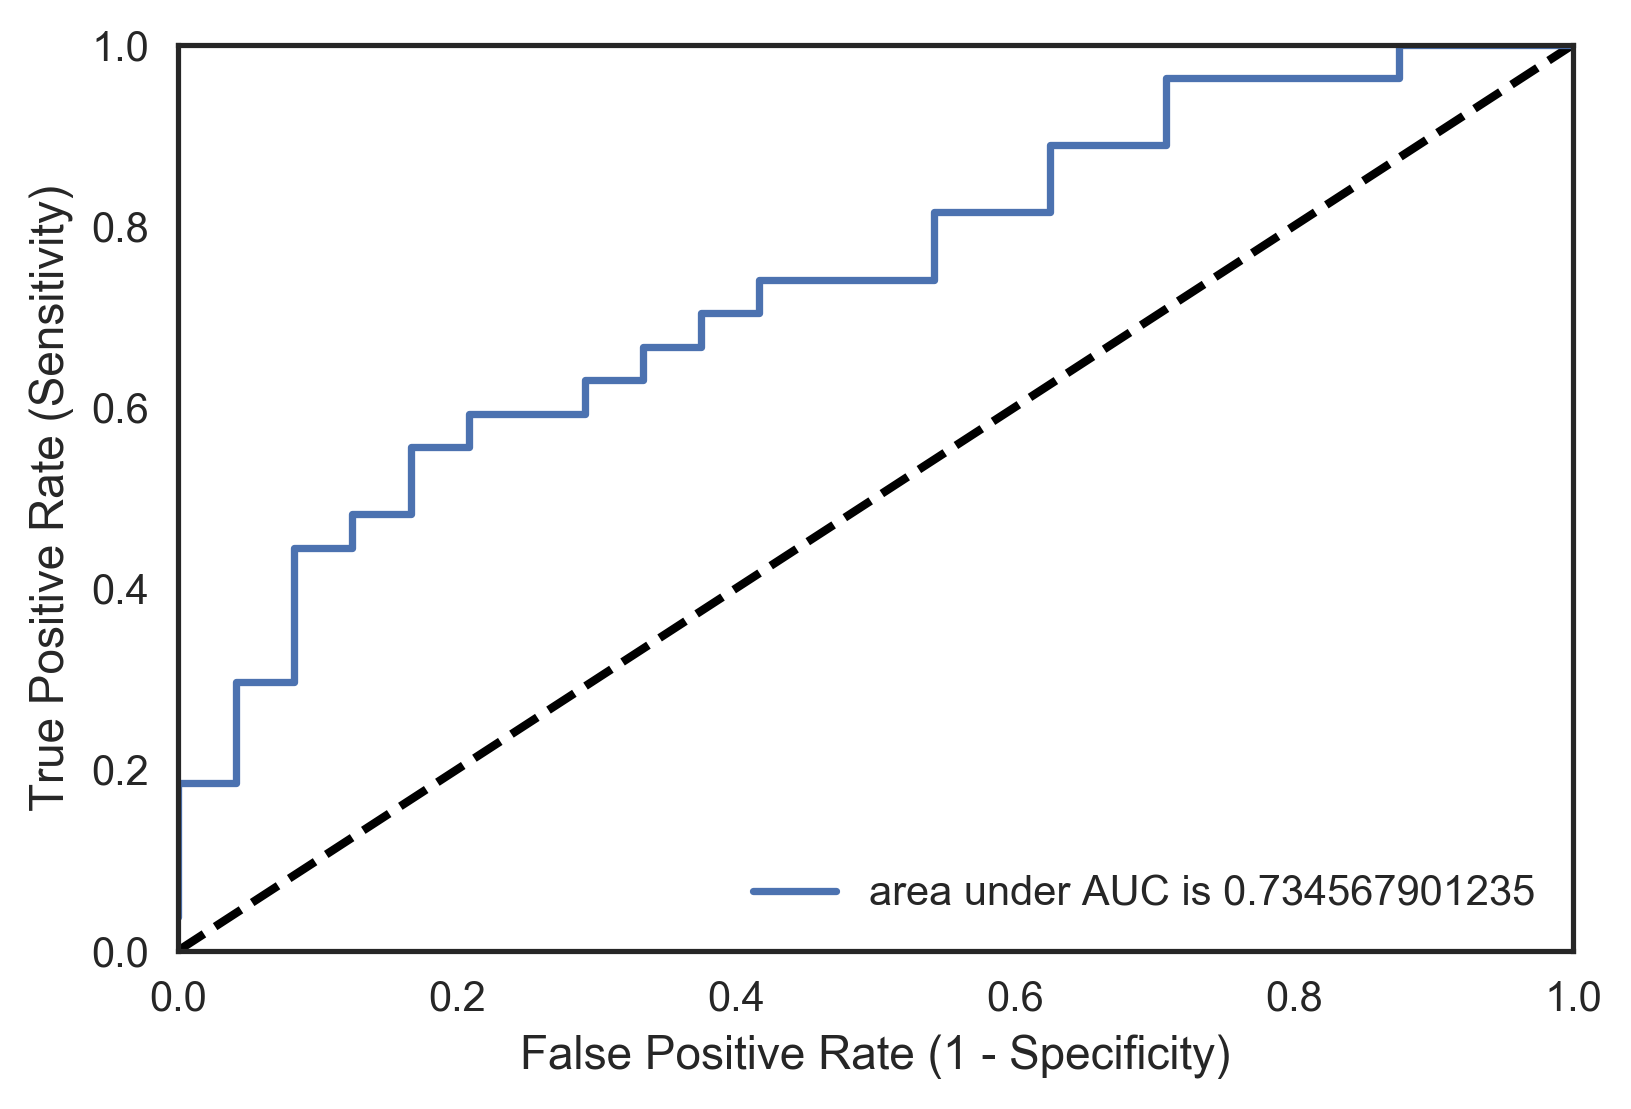

[ 0.40660443]
auc =  0.734567901235


D:\Anaconda\Anaconda\lib\site-packages\ipykernel\__main__.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [254]:
X_lasso,y_lasso,features_lasso = lasso_filter(X,y,6)
X_test_feature = DataFrame(X_test,index=X_test.index,columns=X_lasso.columns)
X_test_feature.to_csv('E:\\HYHY1113\\data_analysis\\jidasan-suihe\\liangexing\\C_lasso_Test.csv')

model,mean_auc = model_training(X_lasso,y_lasso,clf,3)

y_pred_test,y_proba_test = model_testing(model,X_test_feature,y_test)
auc_report(y_test,y_pred_test,y_proba_test)